In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
from pathlib import Path
import os
from datetime import datetime
import re
import math
import numpy as np

In [3]:
def images(best_or_worst): # best_or_worst == True -> best images
    if best_or_worst:
        prefix = "best"
    else:
        prefix = "worst"
    
    dirpath="/s/bach/b/class/cs535/cs535a/data/eval_results"
    savedirpath=f"/s/chopin/n/under/voleskyj/cs535_project/analysis/{prefix}_images148"
    models = ["CNN","LSTM","LSTM_bidirectional"]
    insteps = ["1Day","4Day","8Day"]
    
    for model in models:
        for instep in insteps:
            csv_files = glob.glob(f"{dirpath}/{model}/{instep}/*.csv")

            df_list = []
            for file in csv_files:
                temp_df = pd.read_csv(file)
                df_list.append(temp_df)

            df = pd.concat(df_list, ignore_index=True)
            for outstep in [1,4,8]:
                subdf = df[df["Step"] == outstep]
                if best_or_worst:
                    subdf = subdf.nsmallest(10, 'Real_NDVI_RMSE').sort_values('Real_NDVI_RMSE')
                else:
                    subdf = subdf.nlargest(10, 'Real_NDVI_RMSE').sort_values('Real_NDVI_RMSE',ascending=False)

                i = 1
                for index,image in subdf.iterrows():
                    step = int(image['Step'])
                    sample_num = int(image['GlobalSampleID'])
                    rmse = image['Real_NDVI_RMSE']

                    true_path=f"{dirpath}/{model}/{instep}/{model}_sample{sample_num:05d}_day{step}_true_{instep.lower()}.png"
                    pred_path=f"{dirpath}/{model}/{instep}/{model}_sample{sample_num:05d}_day{step}_pred_{instep.lower()}.png"

                    true_img = mpimg.imread(true_path)
                    pred_img = mpimg.imread(pred_path)

                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
                    plt.subplots_adjust(wspace=0.3, top=0.85, bottom=0.15)

                    ax1.imshow(true_img)
                    ax1.axis('off')
                    ax1.set_title('Truth', fontsize=8)

                    ax2.imshow(pred_img)
                    ax2.axis('off')
                    ax2.set_title('Prediction', fontsize=8)

                    fig.suptitle(f"{model}-{instep} day{step} RMSE: {rmse:.4f}", 
                                fontsize=10, y=0.05, va='bottom')

                    plt.savefig(f"{savedirpath}/{model}_{instep}/{model}_{instep}_{outstep}day_{i}{prefix}.png")
                    plt.close()
                    i+=1

images(True)

GlobalSampleID    19488
Step              19488
Real_NDVI_RMSE    19488
dtype: int64
[1447. 3682. 3808.]


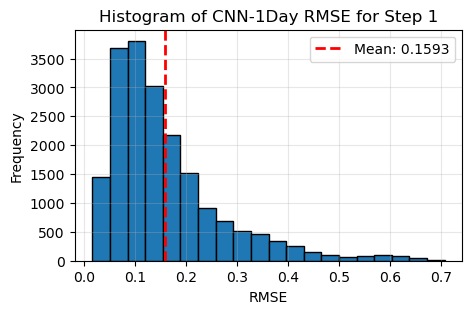

In [13]:
def make_histograms(model,instep):
    csv_files = glob.glob(f"/s/bach/b/class/cs535/cs535a/data/eval_results/{model}/{instep}/*.csv")  # Replace with your actual file path

    df_list = []
    for file in csv_files:
        temp_df = pd.read_csv(file)
        df_list.append(temp_df)

    df = pd.concat(df_list, ignore_index=True)

    #for i in range(9):
    i=1
    if i > 0:
        step_df = df[df['Step'] == i]
        title = f"Histogram of {model}-{instep} RMSE for Step {i}"
        save_file = f"histograms/{model}_{instep}/{model}_{instep}_step{i}.png"
    else:
        step_df = df
        title = f"Histogram of {model}-{instep} RMSE (Total)"
        save_file = f"histograms/{model}_{instep}/{model}_{instep}_total.png"
        
    print(step_df.count())

    plt.figure(figsize=(5, 3))
    counts, bin_edges, patches = plt.hist(step_df['Real_NDVI_RMSE'], bins=20, edgecolor='black')
    print(counts[:3])
    plt.title(title)
    plt.xlabel('RMSE')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

    avg_value=step_df['Real_NDVI_RMSE'].mean()

    plt.axvline(avg_value, color='red', linestyle='--', linewidth=2, 
        label=f'Mean: {avg_value:.4f}')

    plt.legend()

    #plt.savefig(save_file)
    plt.show()
    plt.close()

make_histograms("CNN", "1Day")

In [30]:
def get_average_rmse():
    models = ["CNN","LSTM","LSTM_bidirectional"]
    insteps = ["1Day","4Day","8Day"]
    csv = "model,instep,step,avg_rmse\n" # step==0 is average rmse across all steps
    for model in models:
        for instep in insteps:
            for step in range(9):
                csv_files = glob.glob(f"/s/bach/b/class/cs535/cs535a/data/eval_results/{model}/{instep}/*.csv")  # Replace with your actual file path

                df_list = []
                for file in csv_files:
                    temp_df = pd.read_csv(file)
                    if step > 0:
                        df_list.append(temp_df[temp_df['Step'] == step])
                    else:
                        df_list.append(temp_df)

                df = pd.concat(df_list, ignore_index=True)

                csv += f"{model},{instep},{step},{df['Real_NDVI_RMSE'].mean()}\n"
                
    with open('/s/chopin/n/under/voleskyj/cs535_project/analysis/average_rmse.csv', 'w') as f:
        f.write(csv)

get_average_rmse()

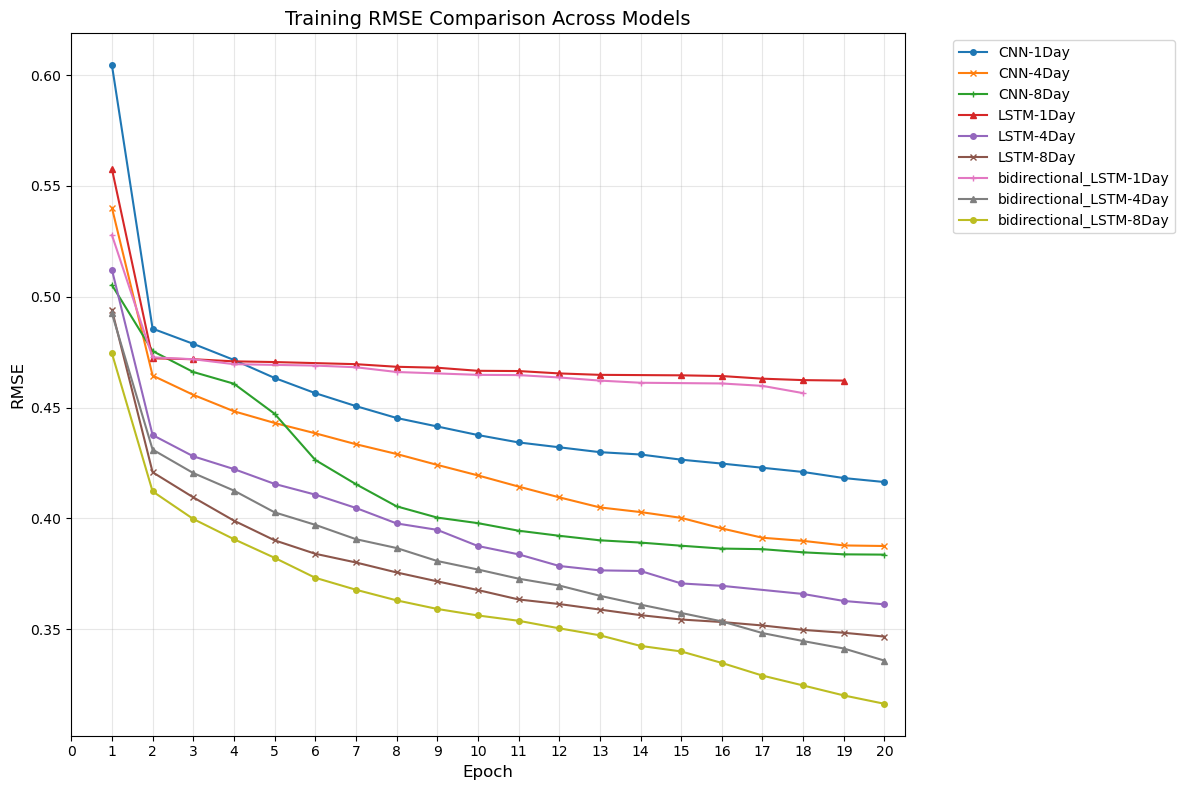

In [22]:
def graph_training_loss():
    dirpath = "/s/bach/b/class/cs535/cs535a/data/new_models/"
    models = ["CNN", "LSTM", "bidirectional_LSTM"]
    insteps = ["1Day", "4Day", "8Day"]
    
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10.colors
    
    markers=['o','x','+','^']
    marker_index=0
    
    for model_idx, model in enumerate(models):
        for instep_idx, instep in enumerate(insteps):
            with open(f"{dirpath}/{instep.lower()}_{model}_model_log.txt", 'r') as f:
                log_lines = f.readlines()

#             rmse_values = []
#             timestamps = []

#             for line in log_lines:
#                 mse_match = re.search(r'MSE (\d+\.\d+)', line)
#                 if mse_match:
#                     rmse_values.append(math.sqrt(float(mse_match.group(1))))

#                 time_match = re.search(r'at (.+)$', line)
#                 if time_match:
#                     timestamps.append(datetime.strptime(time_match.group(1), '%Y-%m-%d %H:%M:%S.%f'))

#             df = pd.DataFrame({'timestamp': timestamps, 'rmse': rmse_values})
#             df = df.sort_values('timestamp')
            df = pd.read_csv(f"/s/chopin/n/under/voleskyj/cs535_project/analysis/loss_csvs/{model}_{instep}_loss.csv")

            # Plot with unique label and color
            label = f"{model}-{instep}"
            color = colors[model_idx * len(insteps) + instep_idx]
            plt.plot(df['epoch'],df['rmse'], 
                     marker=markers[marker_index%len(markers)], 
                     linestyle='-',
                     markersize=4,
                     label=label,
                     color=color)
            marker_index+=1
            
    plt.title('Training RMSE Comparison Across Models', fontsize=14)
    plt.xlim(0, 20.5)  # Set range from 0 to 20
    plt.xticks(range(0, 21, 1))  # Show every integer from 0 to 20
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    #plt.savefig('/s/chopin/n/under/voleskyj/cs535_project/analysis/training_loss.png')
    plt.close()
    
    
graph_training_loss()

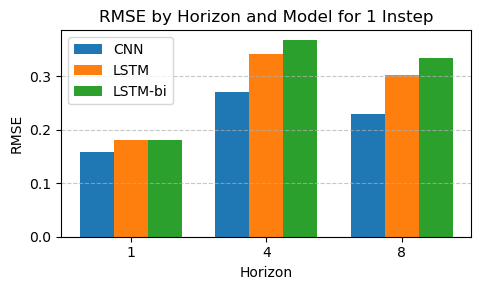

In [12]:
insteps = ['CNN', 'CNN', 'CNN', 'LSTM', 'LSTM', 'LSTM', 'LSTM-bi', 'LSTM-bi', 'LSTM-bi']
horizons = [1, 4, 8, 1, 4, 8, 1, 4, 8]
rmse_values = [0.159,0.271,0.230, 0.182,0.342,0.303, 0.182,0.368,0.335] #1 instep
#rmse_values = [0.168,0.262,0.278, 0.189,0.331,0.316, 0.189,0.320,0.311] #4 instep
#rmse_values = [0.189,0.307,0.266, 0.235,0.369,0.281, 0.234,0.358,0.288] #8 instep

unique_horizons = sorted(set(horizons))
unique_insteps = sorted(set(insteps))
bar_width = 0.25
index = np.arange(len(unique_horizons))

plt.figure(figsize=(5, 3))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, instep in enumerate(unique_insteps):
    rmse = [r for ins, r in zip(insteps, rmse_values) if ins == instep]
    plt.bar(index + i*bar_width, rmse, bar_width, 
            label=f'{instep}', color=colors[i])

plt.xlabel('Horizon')
plt.ylabel('RMSE')
plt.title('RMSE by Horizon and Model for 1 Instep')
plt.xticks(index + bar_width, unique_horizons)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()